In [1]:
# Cell 1: Imports and Setup
import os
os.environ["TRANSFORMERS_NO_TF"] = "1" 
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import yaml
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap

# Checking device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 

c:\Users\PREETI\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# # Cell 2: Load and preprocess data
# import pandas as pd
# import re  
# import yaml 
# from sklearn.model_selection import train_test_split 

# def load_taxonomy(path="taxonomy.yaml"):
#     with open(path, "r") as f:
#         return yaml.safe_load(f)["categories"]

# def clean_text(text):
#     text = str(text).lower()
#     text = re.sub(r'[^a-z0-9\s]', '', text)
#     return text.strip()

# # Load dataset CSV (path adapt as needed)
# df = pd.read_csv("data/daily_transactions.csv")
# # Adjust column names accordingly: assume 'transaction' and 'category'
# df['clean_transaction'] = df['Note'].apply(clean_text)

# # Load user-defined taxonomy and filter data accordingly
# taxonomy = load_taxonomy()
# df = df[df['Category'].isin(taxonomy)]
# label2id = {label: i for i, label in enumerate(taxonomy)}
# id2label = {i: label for label, i in label2id.items()}
# df['label_id'] = df['Category'].map(label2id)

# # Train/validation split
# train_df, val_df = train_test_split(df, test_size=0.1, random_state=42 , stratify=df['label_id'])
# print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")  
# Cell 2: Load and preprocess data
import pandas as pd
import re 
import yaml 
from sklearn.model_selection import train_test_split 

def load_taxonomy(path="taxonomy.yaml"):
    with open(path, "r") as f:
        # Note: We return the full taxonomy, but filter in the main script
        return yaml.safe_load(f)["categories"]

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

# Load dataset CSV (path adapt as needed)
df = pd.read_csv("data/daily_transactions.csv")
# Adjust column names accordingly: assume 'transaction' and 'category'
df['clean_transaction'] = df['Note'].apply(clean_text)

# Load user-defined taxonomy and filter data accordingly
taxonomy = load_taxonomy()
# Use .copy() to avoid SettingWithCopyWarning
df_filtered = df[df['Category'].isin(taxonomy)].copy() 

# --- START OF FIX: Filter out single-instance classes for stratification ---
class_counts = df_filtered['Category'].value_counts()
small_classes = class_counts[class_counts < 2].index
initial_len = len(df_filtered)

# Keep only categories with 2 or more instances
df_filtered = df_filtered[~df_filtered['Category'].isin(small_classes)].copy()

# Recalculate label mapping using only the remaining classes
new_taxonomy = sorted(df_filtered['Category'].unique())
label2id = {label: i for i, label in enumerate(new_taxonomy)}
id2label = {i: label for label, i in label2id.items()}

# Apply new label IDs to the filtered DataFrame
df_filtered['label_id'] = df_filtered['Category'].map(label2id)

print(f"Removed {initial_len - len(df_filtered)} samples (from {len(small_classes)} categories with < 2 instances).")
print(f"Total categories now: {len(new_taxonomy)}.")
# --- END OF FIX ---


# Train/validation split - using the filtered DataFrame and its label_id
# Note: You must use the filtered data (df_filtered) and its label_id for stratification
train_df, val_df = train_test_split(
    df_filtered, 
    test_size=0.1, 
    random_state=42, 
    stratify=df_filtered['label_id'] # Use the filtered label IDs
)
print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")

Removed 3 samples (from 3 categories with < 2 instances).
Total categories now: 47.
Train samples: 2212, Validation samples: 246


In [3]:
# Cell 3: Dataset class definition for HuggingFace Trainer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class TransactionDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encodings = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=64, return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TransactionDataset(list(train_df.clean_transaction), list(train_df.label_id))
val_dataset = TransactionDataset(list(val_df.clean_transaction), list(val_df.label_id))

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


In [4]:
# Cell 4: Model setup and training arguments
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(new_taxonomy),
    id2label=id2label,
    label2id=label2id
).to(device)

training_args = TrainingArguments(
    output_dir="./models",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    # ⚠️ FIX 1: Use the correct, non-deprecated parameter name
    eval_strategy="epoch",  
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    seed=42,
    # ⚠️ FIX 2: Explicitly disable reporting to prevent TensorFlow callbacks from loading
    report_to=["none"] 
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Cell 5: Metrics calculation function for evaluation    
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    f1 = f1_score(labels, preds, average='macro')
    return {"macro_f1": f1}

In [6]:
# Cell 6: Trainer initialization and model training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# Save model and tokenizer locally for offline inference
trainer.save_model("./models/finetuned_model")
tokenizer.save_pretrained("./models/finetuned_model")

  2%|▏         | 50/2770 [00:57<50:17,  1.11s/it] 

{'loss': 2.8409, 'grad_norm': 5.463804721832275, 'learning_rate': 4.909747292418773e-05, 'epoch': 0.18}


  4%|▎         | 100/2770 [02:15<1:02:37,  1.41s/it]

{'loss': 2.0508, 'grad_norm': 4.436103820800781, 'learning_rate': 4.819494584837546e-05, 'epoch': 0.36}


  5%|▌         | 150/2770 [03:15<51:37,  1.18s/it]  

{'loss': 1.5073, 'grad_norm': 7.403022289276123, 'learning_rate': 4.7292418772563177e-05, 'epoch': 0.54}


  7%|▋         | 200/2770 [04:13<50:53,  1.19s/it]

{'loss': 1.602, 'grad_norm': 12.737686157226562, 'learning_rate': 4.63898916967509e-05, 'epoch': 0.72}


  9%|▉         | 250/2770 [05:13<49:23,  1.18s/it]

{'loss': 1.4362, 'grad_norm': 2.1498289108276367, 'learning_rate': 4.548736462093863e-05, 'epoch': 0.9}


                                                  
 10%|█         | 277/2770 [05:50<47:26,  1.14s/it]

{'eval_loss': 1.2954490184783936, 'eval_macro_f1': 0.255381862668853, 'eval_runtime': 4.9594, 'eval_samples_per_second': 49.603, 'eval_steps_per_second': 1.613, 'epoch': 1.0}


 11%|█         | 300/2770 [06:17<50:31,  1.23s/it]  

{'loss': 1.2935, 'grad_norm': 6.469908714294434, 'learning_rate': 4.458483754512636e-05, 'epoch': 1.08}


 13%|█▎        | 350/2770 [07:32<57:04,  1.42s/it]  

{'loss': 1.1245, 'grad_norm': 9.625361442565918, 'learning_rate': 4.368231046931408e-05, 'epoch': 1.26}


 14%|█▍        | 400/2770 [09:40<38:24,  1.03it/s]  

{'loss': 1.1983, 'grad_norm': 8.897088050842285, 'learning_rate': 4.277978339350181e-05, 'epoch': 1.44}


 16%|█▌        | 450/2770 [10:37<44:48,  1.16s/it]

{'loss': 1.0467, 'grad_norm': 9.629122734069824, 'learning_rate': 4.187725631768953e-05, 'epoch': 1.62}


 18%|█▊        | 500/2770 [11:34<44:32,  1.18s/it]

{'loss': 1.0227, 'grad_norm': 4.456127643585205, 'learning_rate': 4.0974729241877256e-05, 'epoch': 1.81}


 20%|█▉        | 550/2770 [12:31<41:51,  1.13s/it]

{'loss': 1.1983, 'grad_norm': 9.1160249710083, 'learning_rate': 4.007220216606498e-05, 'epoch': 1.99}


                                                  
 20%|██        | 554/2770 [12:41<41:20,  1.12s/it]

{'eval_loss': 1.1599339246749878, 'eval_macro_f1': 0.29821165980231606, 'eval_runtime': 5.0751, 'eval_samples_per_second': 48.472, 'eval_steps_per_second': 1.576, 'epoch': 2.0}


 22%|██▏       | 600/2770 [13:35<40:38,  1.12s/it]  

{'loss': 0.9874, 'grad_norm': 6.54360294342041, 'learning_rate': 3.916967509025271e-05, 'epoch': 2.17}


 23%|██▎       | 650/2770 [14:31<41:27,  1.17s/it]

{'loss': 0.9228, 'grad_norm': 5.866254806518555, 'learning_rate': 3.826714801444044e-05, 'epoch': 2.35}


 25%|██▌       | 700/2770 [15:29<39:13,  1.14s/it]

{'loss': 0.8733, 'grad_norm': 3.5358827114105225, 'learning_rate': 3.7364620938628155e-05, 'epoch': 2.53}


 27%|██▋       | 750/2770 [16:28<40:13,  1.20s/it]

{'loss': 0.8104, 'grad_norm': 6.4694976806640625, 'learning_rate': 3.646209386281589e-05, 'epoch': 2.71}


 29%|██▉       | 800/2770 [17:27<38:57,  1.19s/it]

{'loss': 1.0329, 'grad_norm': 5.2756218910217285, 'learning_rate': 3.555956678700361e-05, 'epoch': 2.89}


                                                  
 30%|███       | 831/2770 [18:10<40:16,  1.25s/it]

{'eval_loss': 1.148919701576233, 'eval_macro_f1': 0.2923173674185812, 'eval_runtime': 5.1576, 'eval_samples_per_second': 47.697, 'eval_steps_per_second': 1.551, 'epoch': 3.0}


 31%|███       | 850/2770 [18:33<34:36,  1.08s/it]  

{'loss': 0.8946, 'grad_norm': 3.255516290664673, 'learning_rate': 3.4657039711191336e-05, 'epoch': 3.07}


 32%|███▏      | 900/2770 [19:32<37:17,  1.20s/it]

{'loss': 0.9139, 'grad_norm': 2.318920135498047, 'learning_rate': 3.375451263537907e-05, 'epoch': 3.25}


 34%|███▍      | 950/2770 [20:40<41:53,  1.38s/it]

{'loss': 0.7492, 'grad_norm': 3.6169562339782715, 'learning_rate': 3.2851985559566786e-05, 'epoch': 3.43}


 36%|███▌      | 1000/2770 [21:49<40:27,  1.37s/it]

{'loss': 0.7326, 'grad_norm': 2.8052070140838623, 'learning_rate': 3.194945848375451e-05, 'epoch': 3.61}


 38%|███▊      | 1050/2770 [23:01<43:31,  1.52s/it]

{'loss': 0.9196, 'grad_norm': 10.701132774353027, 'learning_rate': 3.104693140794224e-05, 'epoch': 3.79}


 40%|███▉      | 1100/2770 [24:10<39:03,  1.40s/it]

{'loss': 0.8508, 'grad_norm': 11.708614349365234, 'learning_rate': 3.0144404332129967e-05, 'epoch': 3.97}


                                                   
 40%|████      | 1108/2770 [24:27<37:02,  1.34s/it]

{'eval_loss': 1.160249948501587, 'eval_macro_f1': 0.3735598912096608, 'eval_runtime': 6.286, 'eval_samples_per_second': 39.134, 'eval_steps_per_second': 1.273, 'epoch': 4.0}


 42%|████▏     | 1150/2770 [25:26<37:05,  1.37s/it]  

{'loss': 0.8056, 'grad_norm': 5.660031795501709, 'learning_rate': 2.924187725631769e-05, 'epoch': 4.15}


 43%|████▎     | 1200/2770 [26:34<33:45,  1.29s/it]

{'loss': 0.7779, 'grad_norm': 2.817603826522827, 'learning_rate': 2.8339350180505413e-05, 'epoch': 4.33}


 45%|████▌     | 1250/2770 [27:43<34:42,  1.37s/it]

{'loss': 0.7659, 'grad_norm': 3.428396224975586, 'learning_rate': 2.7436823104693144e-05, 'epoch': 4.51}


 47%|████▋     | 1300/2770 [28:52<32:28,  1.33s/it]

{'loss': 0.8337, 'grad_norm': 3.420522451400757, 'learning_rate': 2.6534296028880866e-05, 'epoch': 4.69}


 49%|████▊     | 1350/2770 [30:01<33:32,  1.42s/it]

{'loss': 0.6649, 'grad_norm': 6.067725658416748, 'learning_rate': 2.563176895306859e-05, 'epoch': 4.87}


                                                   
 50%|█████     | 1385/2770 [30:57<30:53,  1.34s/it]

{'eval_loss': 1.1328606605529785, 'eval_macro_f1': 0.41830399501858523, 'eval_runtime': 6.2113, 'eval_samples_per_second': 39.605, 'eval_steps_per_second': 1.288, 'epoch': 5.0}


 51%|█████     | 1400/2770 [31:19<33:05,  1.45s/it]  

{'loss': 0.8383, 'grad_norm': 4.073631286621094, 'learning_rate': 2.472924187725632e-05, 'epoch': 5.05}


 52%|█████▏    | 1450/2770 [32:30<31:07,  1.41s/it]

{'loss': 0.68, 'grad_norm': 3.869581460952759, 'learning_rate': 2.3826714801444043e-05, 'epoch': 5.23}


 54%|█████▍    | 1500/2770 [33:34<21:45,  1.03s/it]

{'loss': 0.6719, 'grad_norm': 3.8953375816345215, 'learning_rate': 2.292418772563177e-05, 'epoch': 5.42}


 56%|█████▌    | 1550/2770 [34:31<22:21,  1.10s/it]

{'loss': 0.6894, 'grad_norm': 2.6869561672210693, 'learning_rate': 2.2021660649819496e-05, 'epoch': 5.6}


 58%|█████▊    | 1600/2770 [35:31<22:46,  1.17s/it]

{'loss': 0.7902, 'grad_norm': 4.878635406494141, 'learning_rate': 2.111913357400722e-05, 'epoch': 5.78}


 60%|█████▉    | 1650/2770 [36:31<22:27,  1.20s/it]

{'loss': 0.8329, 'grad_norm': 3.050752878189087, 'learning_rate': 2.0216606498194946e-05, 'epoch': 5.96}


                                                   
 60%|██████    | 1662/2770 [36:51<21:20,  1.16s/it]

{'eval_loss': 1.1906723976135254, 'eval_macro_f1': 0.4168329693641979, 'eval_runtime': 4.9553, 'eval_samples_per_second': 49.644, 'eval_steps_per_second': 1.614, 'epoch': 6.0}


 61%|██████▏   | 1700/2770 [37:37<20:53,  1.17s/it]

{'loss': 0.7506, 'grad_norm': 4.270972728729248, 'learning_rate': 1.9314079422382674e-05, 'epoch': 6.14}


 63%|██████▎   | 1750/2770 [38:37<20:30,  1.21s/it]

{'loss': 0.7417, 'grad_norm': 4.161159515380859, 'learning_rate': 1.84115523465704e-05, 'epoch': 6.32}


 65%|██████▍   | 1800/2770 [39:37<18:58,  1.17s/it]

{'loss': 0.7374, 'grad_norm': 3.699134349822998, 'learning_rate': 1.7509025270758123e-05, 'epoch': 6.5}


 67%|██████▋   | 1850/2770 [40:37<18:13,  1.19s/it]

{'loss': 0.5952, 'grad_norm': 3.8164918422698975, 'learning_rate': 1.6606498194945848e-05, 'epoch': 6.68}


 69%|██████▊   | 1900/2770 [41:37<17:20,  1.20s/it]

{'loss': 0.8336, 'grad_norm': 2.984396457672119, 'learning_rate': 1.5703971119133576e-05, 'epoch': 6.86}


                                                   
 70%|███████   | 1939/2770 [42:29<15:44,  1.14s/it]

{'eval_loss': 1.1507105827331543, 'eval_macro_f1': 0.38622307303250647, 'eval_runtime': 4.8854, 'eval_samples_per_second': 50.354, 'eval_steps_per_second': 1.638, 'epoch': 7.0}


 70%|███████   | 1950/2770 [42:43<17:18,  1.27s/it]

{'loss': 0.6542, 'grad_norm': 2.7700729370117188, 'learning_rate': 1.4801444043321299e-05, 'epoch': 7.04}


 72%|███████▏  | 2000/2770 [43:43<15:00,  1.17s/it]

{'loss': 0.706, 'grad_norm': 1.5526316165924072, 'learning_rate': 1.3898916967509026e-05, 'epoch': 7.22}


 74%|███████▍  | 2050/2770 [44:42<14:17,  1.19s/it]

{'loss': 0.752, 'grad_norm': 3.480020046234131, 'learning_rate': 1.299638989169675e-05, 'epoch': 7.4}


 76%|███████▌  | 2100/2770 [45:42<13:31,  1.21s/it]

{'loss': 0.6125, 'grad_norm': 4.907046794891357, 'learning_rate': 1.2093862815884477e-05, 'epoch': 7.58}


 78%|███████▊  | 2150/2770 [46:41<12:05,  1.17s/it]

{'loss': 0.7038, 'grad_norm': 2.7387444972991943, 'learning_rate': 1.1191335740072201e-05, 'epoch': 7.76}


 79%|███████▉  | 2200/2770 [47:42<11:29,  1.21s/it]

{'loss': 0.6913, 'grad_norm': 4.939020156860352, 'learning_rate': 1.028880866425993e-05, 'epoch': 7.94}


                                                   
 80%|████████  | 2216/2770 [48:05<09:15,  1.00s/it]

{'eval_loss': 1.1791563034057617, 'eval_macro_f1': 0.41756301024383574, 'eval_runtime': 5.0443, 'eval_samples_per_second': 48.768, 'eval_steps_per_second': 1.586, 'epoch': 8.0}


 81%|████████  | 2250/2770 [48:44<09:56,  1.15s/it]

{'loss': 0.7751, 'grad_norm': 4.088379383087158, 'learning_rate': 9.386281588447654e-06, 'epoch': 8.12}


 83%|████████▎ | 2300/2770 [49:43<09:24,  1.20s/it]

{'loss': 0.6962, 'grad_norm': 2.710726499557495, 'learning_rate': 8.483754512635379e-06, 'epoch': 8.3}


 85%|████████▍ | 2350/2770 [50:43<08:14,  1.18s/it]

{'loss': 0.659, 'grad_norm': 2.246490001678467, 'learning_rate': 7.581227436823105e-06, 'epoch': 8.48}


 87%|████████▋ | 2400/2770 [51:41<07:08,  1.16s/it]

{'loss': 0.6561, 'grad_norm': 2.3890819549560547, 'learning_rate': 6.678700361010831e-06, 'epoch': 8.66}


 88%|████████▊ | 2450/2770 [52:41<06:16,  1.18s/it]

{'loss': 0.753, 'grad_norm': 3.472083330154419, 'learning_rate': 5.776173285198557e-06, 'epoch': 8.84}


                                                   
 90%|█████████ | 2493/2770 [53:37<05:02,  1.09s/it]

{'eval_loss': 1.1776517629623413, 'eval_macro_f1': 0.4306690760207089, 'eval_runtime': 4.9457, 'eval_samples_per_second': 49.74, 'eval_steps_per_second': 1.618, 'epoch': 9.0}


 90%|█████████ | 2500/2770 [53:47<06:32,  1.45s/it]

{'loss': 0.72, 'grad_norm': 3.6550025939941406, 'learning_rate': 4.873646209386281e-06, 'epoch': 9.03}


 92%|█████████▏| 2550/2770 [54:47<04:22,  1.19s/it]

{'loss': 0.621, 'grad_norm': 4.691079616546631, 'learning_rate': 3.971119133574008e-06, 'epoch': 9.21}


 94%|█████████▍| 2600/2770 [55:46<03:22,  1.19s/it]

{'loss': 0.6964, 'grad_norm': 5.065377235412598, 'learning_rate': 3.068592057761733e-06, 'epoch': 9.39}


 96%|█████████▌| 2650/2770 [56:44<02:22,  1.19s/it]

{'loss': 0.5928, 'grad_norm': 5.27712869644165, 'learning_rate': 2.1660649819494585e-06, 'epoch': 9.57}


 97%|█████████▋| 2700/2770 [57:44<01:21,  1.16s/it]

{'loss': 0.7993, 'grad_norm': 3.4782228469848633, 'learning_rate': 1.263537906137184e-06, 'epoch': 9.75}


 99%|█████████▉| 2750/2770 [58:43<00:23,  1.16s/it]

{'loss': 0.6375, 'grad_norm': 4.19179105758667, 'learning_rate': 3.610108303249098e-07, 'epoch': 9.93}


                                                   
100%|██████████| 2770/2770 [59:14<00:00,  1.14s/it]

{'eval_loss': 1.1749153137207031, 'eval_macro_f1': 0.430283937349856, 'eval_runtime': 5.5716, 'eval_samples_per_second': 44.152, 'eval_steps_per_second': 1.436, 'epoch': 10.0}


100%|██████████| 2770/2770 [59:16<00:00,  1.28s/it]


{'train_runtime': 3556.3984, 'train_samples_per_second': 6.22, 'train_steps_per_second': 0.779, 'train_loss': 0.9042794065785322, 'epoch': 10.0}


('./models/finetuned_model\\tokenizer_config.json',
 './models/finetuned_model\\special_tokens_map.json',
 './models/finetuned_model\\vocab.txt',
 './models/finetuned_model\\added_tokens.json',
 './models/finetuned_model\\tokenizer.json')

In [13]:
# Cell 7: Inference function with confidence
def predict_category(text):
    model.eval()
    encoding = tokenizer(clean_text(text), return_tensors="pt", truncation=True, padding=True, max_length=64).to(device)
    with torch.no_grad():
        outputs = model(**encoding)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    pred_idx = probs.argmax()
    return id2label[pred_idx], probs[pred_idx], probs

# Example inference
example_transaction = "reliance stock payment"
category, confidence, scores = predict_category(example_transaction)
print(f"Transaction: {example_transaction}\nPredicted Category: {category} (Confidence: {confidence:.2f})")


Transaction: reliance stock payment
Predicted Category: Dividend earned on Shares (Confidence: 0.33)


In [8]:
# Cell 8: Explainability with SHAP (optional, can be computationally intense)
explainer = shap.Explainer(model, tokenizer)
def explain_prediction(text):
    text_cleaned = clean_text(text)
    shap_values = explainer([text_cleaned])
    shap.plots.text(shap_values[0])


In [9]:
# Cell 9: Feedback mechanism (simple append feedback to csv)
def save_feedback(transaction, correct_category):
    feedback_df = pd.DataFrame([[transaction, correct_category]], columns=['transaction', 'correct_category'])
    feedback_df.to_csv("data/feedback.csv", mode='a', header=False, index=False)


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# import torch
# import yaml
# import re

# # Load taxonomy
# def load_taxonomy(path="config/taxonomy.yaml"):
#     with open(path, "r") as f:
#         return yaml.safe_load(f)["categories"]

# def clean_text(text):
#     text = str(text).lower()
#     text = re.sub(r'[^a-z0-9\s]', '', text)
#     return text.strip()

# taxonomy = load_taxonomy()
# label2id = {label: i for i, label in enumerate(taxonomy)}
# id2label = {i: label for label, i in label2id.items()}

# # Load original dataset
# orig_df = pd.read_csv("data/daily_transactions.csv")
# orig_df['clean_transaction'] = orig_df['transaction'].apply(clean_text)
# orig_df = orig_df[orig_df['category'].isin(taxonomy)]
# orig_df['label_id'] = orig_df['category'].map(label2id)

# # Load feedback dataset
# fb_df = pd.read_csv("data/feedback.csv", names=['transaction', 'correct_category'])
# fb_df['clean_transaction'] = fb_df['transaction'].apply(clean_text)
# fb_df = fb_df[fb_df['correct_category'].isin(taxonomy)]
# fb_df['label_id'] = fb_df['correct_category'].map(label2id)

# # Combine datasets
# combined_df = pd.concat([orig_df[['clean_transaction', 'label_id']], fb_df[['clean_transaction', 'label_id']]], 
#                         ignore_index=True)

# # Train/val split
# train_df, val_df = train_test_split(combined_df, test_size=0.1, random_state=42, stratify=combined_df['label_id'])

# # Load tokenizer and model from saved directory
# model_path = "./models/finetuned_model"
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModelForSequenceClassification.from_pretrained(model_path)

# # Prepare datasets for Trainer
# class TransactionDataset(torch.utils.data.Dataset):
#     def __init__(self, texts, labels):
#         self.texts = texts
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         encodings = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=64, return_tensors="pt")
#         item = {key: val.squeeze(0) for key, val in encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

# train_dataset = TransactionDataset(list(train_df.clean_transaction), list(train_df.label_id))
# val_dataset = TransactionDataset(list(val_df.clean_transaction), list(val_df.label_id))

# # Training arguments for retraining
# training_args = TrainingArguments(
#     output_dir="./models/finetuned_model_retrained",
#     num_train_epochs=2,  # Few epochs to avoid overfitting
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     logging_dir='./logs',
#     learning_rate=2e-5,  # Lower learning rate on fine-tuning
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     seed=42
# )

# # Metric function
# from sklearn.metrics import f1_score
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = logits.argmax(axis=-1)
#     return {"macro_f1": f1_score(labels, preds, average='macro')}

# # Trainer with model reloaded
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

# # Retrain
# trainer.train()

# # Save the retrained model
# trainer.save_model("./models/finetuned_model_retrained")
# tokenizer.save_pretrained("./models/finetuned_model_retrained")


FileNotFoundError: [Errno 2] No such file or directory: 'config/taxonomy.yaml'

**Macro F1 Score (Validation): 0.4183**
--------------------------------------------------
Number of classes present in validation set (True + Predicted): 35
--------------------------------------------------
                           precision    recall  f1-score   support

                  Apparel       1.00      0.80      0.89         5
                   Beauty       1.00      1.00      1.00         2
                    Bonus       1.00      1.00      1.00         1
                  Culture       1.00      1.00      1.00         1
Dividend earned on Shares       1.00      1.00      1.00         1
                Education       0.50      1.00      0.67         2
     Equity Mutual Fund A       0.00      0.00      0.00         1
     Equity Mutual Fund C       0.00      0.00      0.00         1
     Equity Mutual Fund E       0.00      0.00      0.00         2
     Equity Mutual Fund F       0.00      0.00      0.00         1
                   Family       0.00      0.00      0

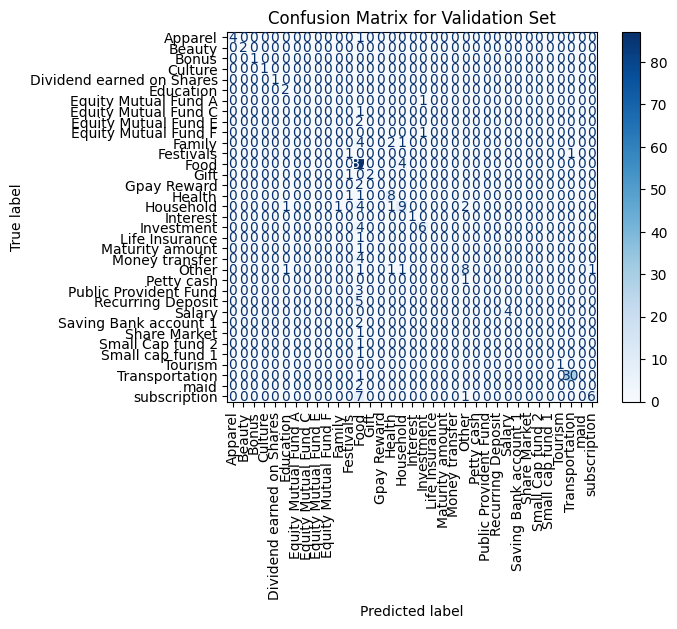

In [11]:
# # Cell 10: Metrics evaluation on validation dataset (macro F1, confusion matrix)
# val_texts = list(val_df.clean_transaction)
# val_labels = list(val_df.label_id)
# preds = []
# for text in val_texts:
#     pred_label, _, _ = predict_category(text)
#     preds.append(label2id[pred_label])

# from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# print(classification_report(val_labels, preds, target_names=taxonomy))

# cm = confusion_matrix(val_labels, preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=taxonomy)
# disp.plot(xticks_rotation='vertical')
# plt.show() 

# Cell 10: Metrics evaluation on validation dataset (macro F1, confusion matrix)
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

val_texts = list(val_df.clean_transaction)
val_labels = list(val_df.label_id)
preds = []

# --- Prediction Loop ---
# Assuming 'predict_category' from Cell 7 is used, which does NOT take 'classifier' as an argument.
for text in val_texts:
    pred_label, _, _ = predict_category(text) # Corrected to remove 'classifier=None'
    # Check if the predicted label is in the known taxonomy before mapping
    if pred_label in label2id:
        preds.append(label2id[pred_label])
    else:
        # Handle cases where the model might predict an unknown label, 
        # though unlikely in a fine-tuned setting.
        preds.append(-1) # Use an invalid ID or skip

# 1. Get the unique integer IDs present in the TRUE labels AND predicted labels
# This is crucial for a complete report.
unique_labels = sorted(np.unique(val_labels + preds))
# Filter out any placeholder/error labels like -1 if used
present_label_ids = [i for i in unique_labels if i in id2label] 

# 2. Map these present IDs back to their category names
report_target_names = [id2label[i] for i in present_label_ids]

# --- Macro F1 Score Calculation (NEW ADDITION) ---
macro_f1 = f1_score(val_labels, preds, average='macro', labels=present_label_ids, zero_division=0)
print(f"**Macro F1 Score (Validation): {macro_f1:.4f}**")
print("-" * 50)

print(f"Number of classes present in validation set (True + Predicted): {len(present_label_ids)}")
print("-" * 50)

# --- Classification Report ---
# FIX: Use the 'labels' parameter to specify the IDs to report on,
# and use the corresponding 'report_target_names'.
print(classification_report(
    val_labels, 
    preds, 
    labels=present_label_ids, 
    target_names=report_target_names,
    zero_division=0 
))

# --- Confusion Matrix ---
cm = confusion_matrix(val_labels, preds, labels=present_label_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=report_target_names)
disp.plot(xticks_rotation='vertical', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()